In [1]:
import os
import time
import pickle
import datetime
from tqdm import tqdm
from typing import Any, Callable
import optax
import jax
import jax.random as jr
import jax.numpy as np
import numpy 
from jax.flatten_util import ravel_pytree
from jax import Array, vmap
import matplotlib.pyplot as plt
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from svae_control.config import Config
from pathlib import Path


from dataclasses import asdict
from pathlib import Path

import jax
from jax import random as jr
from matplotlib import pyplot as plt

import wandb
from svae_control import network
from svae_control.config import Config
from svae_control.svae import SVAE
from svae_control.train import Trainer
from svae_control.utils.dataclass_utils import LDSParams
from svae_control.utils.setup_utils import get_args, get_beta_schedule, load_dataset
from svae_control.utils.dataclass_utils import InputData
from svae_control.utils.kernel_ridge import GPUKernelRidge, sweep_krr, standardize

CACHE_DIR = 'tests/results'
TOLERANCE = 1e-1

YAML_PREFIX = f"{os.getcwd()}"
PARAM_PREFIX = f"{os.getcwd()}/params/svae"
YAML_PREFIX, PARAM_PREFIX

('/home/james/projects/master_project/svae-control/src/svae_control/notebooks/image_observations',
 '/home/james/projects/master_project/svae-control/src/svae_control/notebooks/image_observations/params/svae')

# Load Data

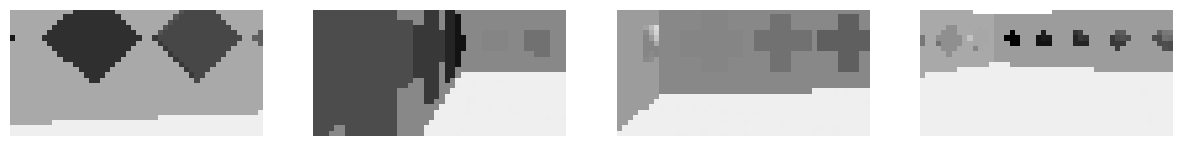

((200, 100, 24, 48), (200, 100, 3), (50, 100, 24, 48), (50, 100, 3))

In [2]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "non_cifar_greyscale_images.npy")) / 255
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

observations = observations[:, :, 18:42, :]

# plot images before flattening 
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(observations[0, i * 30], cmap="grey", vmin=0, vmax=1)
    ax[i].axis("off")
plt.show()

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

In [4]:
# set up training and val data
train_data = InputData(obs=train_X[..., None], targets=train_Y)
val_data = InputData(obs=val_X[..., None], targets=val_Y) 
train_data.obs.shape, val_data.obs.shape

((200, 100, 24, 48, 1), (50, 100, 24, 48, 1))

In [5]:
BEST_SEED = 1
for latent_dim in [5, 10, 16]:

    # Load config with specific seed
    config_dir = f"{YAML_PREFIX}/image_observations_config_seed_{BEST_SEED}_dim_{latent_dim}.yaml"
    yaml_config = Path(config_dir)
    config = Config.from_yaml(yaml_config)
    print("Using latent dimension: ", config.model.latent_dim)

    # generate keys using seed
    key = jr.PRNGKey(config.training.seed)
    data_key, model_key, trainer_key = jr.split(key, 3)

    # to be safe, redefine prior and enc/dec networks for each seed
    prior = LDSParams.init(config.model.latent_dim)
    enc = getattr(network, config.model.encoder.dist_type)(
        config.model.encoder, config.model.latent_dim
    )
    dec = getattr(network, config.model.decoder.dist_type)(
        config.model.decoder, config.data.obs_dim_flat
    )
    
    model = SVAE(
        generation_network=dec, recognition_network=enc, config=config, key=model_key
    )
    trainer = Trainer(
        model=model,
        config=config,
        prior_params=prior,
        beta_schedule=get_beta_schedule(config.training.beta),
        key=trainer_key,
        logger=None,
    )
    
    # fit SVAE
    start = time.perf_counter()
    loss, r2, trained_params = trainer.train(train_data, val_data)
    
    end = time.perf_counter()
    time_elapsed = end - start
    elapsed_filename = f"{PARAM_PREFIX}_time_elapsed_seed_{BEST_SEED}_dim_{latent_dim}.pkl"
    with open(elapsed_filename, 'wb') as f:
        pickle.dump(time_elapsed, f)
    
    # save params
    filename = f"{PARAM_PREFIX}_params_seed_{BEST_SEED}_dim_{latent_dim}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(trainer.params, f)
    
    # save loss tot
    loss = np.array(loss)
    filename = f"{PARAM_PREFIX}_training_loss_seed_{BEST_SEED}_dim_{latent_dim}"
    np.save(filename, loss)

Using latent dimension:  5


2025-09-01 14:58:52.045335: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.

00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [55:24<00:00,  7.52it/s, kl=0.011, loss=1.014, obs_ll=-1.003, r2_post=0.760]

Using latent dimension:  10



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [1:02:08<00:00,  6.70it/s, kl=0.013, loss=1.001, obs_ll=-0.988, r2_post=0.812]

Using latent dimension:  16



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [1:35:43<00:00,  4.35it/s, kl=0.015, loss=1.000, obs_ll=-0.985, r2_post=0.818]

# Plot Loss and Learned A

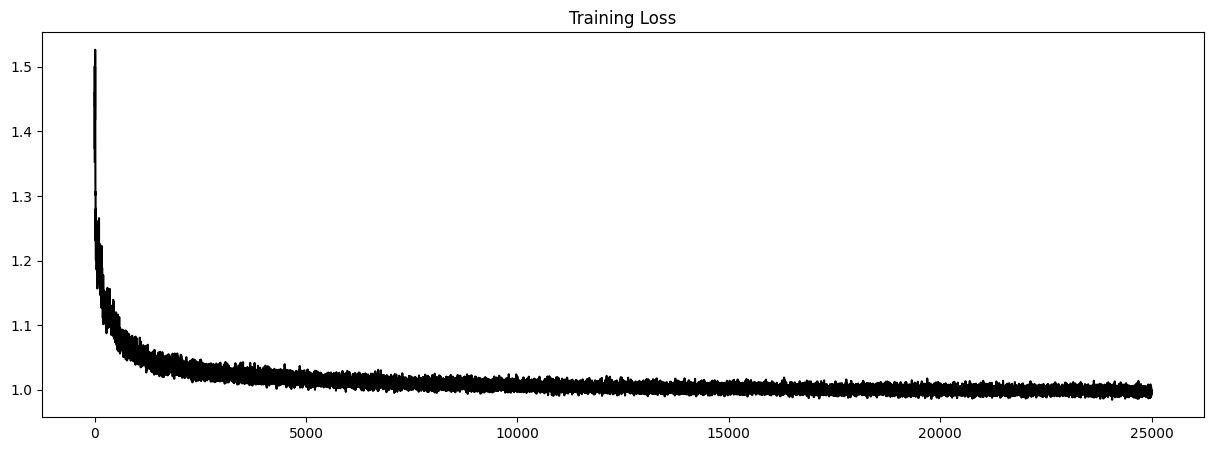

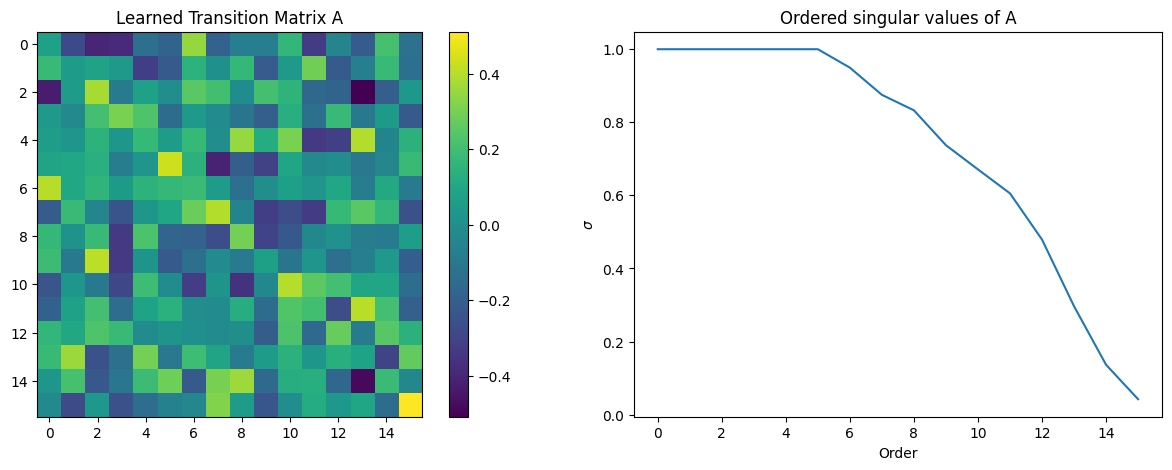

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(loss, color="black")
plt.title("Training Loss")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
A = numpy.array(trainer.params[0].A)
im = ax[0].imshow(A)
ax[0].set_title("Learned Transition Matrix A")
fig.colorbar(im, ax=ax[0])

U, S, VT = numpy.linalg.svd(A)
rank = numpy.linalg.matrix_rank(A)
ax[1].plot(numpy.arange(S.shape[0]), S)
ax[1].set_title("Ordered singular values of A")
ax[1].set_ylabel(r"$\sigma\ $")
ax[1].set_xlabel("Order")

plt.show()

In [10]:
# filename = f"{PARAM_PREFIX}_params_seed_{seed}.pkl"
# print(filename)

# # save loss tot
# filename = f"{PARAM_PREFIX}_training_loss_seed_{seed}.pkl"
# print(filename)

/home/james/projects/master_project/svae-control/src/svae_control/notebooks/noisy_locations/params/svae_params_seed_2.pkl
/home/james/projects/master_project/svae-control/src/svae_control/notebooks/noisy_locations/params/svae_training_loss_seed_2.pkl


In [16]:
# prior = LDSParams.init(config.model.latent_dim)
# enc = getattr(network, config.model.encoder.dist_type)(
#     config.model.encoder, config.model.latent_dim
# )
# dec = getattr(network, config.model.decoder.dist_type)(
#     config.model.decoder, config.data.obs_dim_flat
# )

# model = SVAE(
#     generation_network=dec, recognition_network=enc, config=config, key=model_key
# )
# trainer = Trainer(
#     model=model,
#     config=config,
#     prior_params=prior,
#     beta_schedule=get_beta_schedule(config.training.beta),
#     key=trainer_key,
#     logger=None,
# )
# loss, r2, trained_params = trainer.train(train_data, val_data)


00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:13:45<00:00,  2.26it/s, kl=0.069, loss=1.066, obs_ll=-0.997, r2_post=0.963]

In [31]:
# # save params
# filename = f"{PARAM_PREFIX}_params.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(trainer.params, f)

# # save loss tot
# loss = np.array(loss)
# filename = f"{PARAM_PREFIX}_training_loss.pkl"
# np.save(filename, loss)

# Check Latent Quality with Kernel Ridge

In [8]:
aux_list = []
BEST_SEED = 1
for latent_dim in [5, 10, 16]: 

    # Load config with specific seed
    config_dir = f"{YAML_PREFIX}/image_observations_config_seed_{BEST_SEED}_dim_{latent_dim}.yaml"
    yaml_config = Path(config_dir)
    config = Config.from_yaml(yaml_config)

    # generate keys using seed
    key = jr.PRNGKey(config.training.seed)
    data_key, model_key, trainer_key = jr.split(key, 3)

    # to be safe, redefine prior and enc/dec networks for each seed
    prior = LDSParams.init(config.model.latent_dim)
    enc = getattr(network, config.model.encoder.dist_type)(
        config.model.encoder, config.model.latent_dim
    )
    dec = getattr(network, config.model.decoder.dist_type)(
        config.model.decoder, config.data.obs_dim_flat
    )

    # define SVAE and Trainer
    model = SVAE(
        generation_network=dec, recognition_network=enc, config=config, key=model_key
    )
    trainer = Trainer(
        model=model,
        config=config,
        prior_params=prior,
        beta_schedule=get_beta_schedule(config.training.beta),
        key=trainer_key,
        logger=None,
    )

    # load params
    filename = f"{PARAM_PREFIX}_params_seed_{BEST_SEED}_dim_{latent_dim}.pkl"
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    
    trainer.params = params

    # get posterior estimates
    apply = vmap(model.apply, (None, 0))

    train_ts_means = []
    for i in tqdm(range(train_X.shape[0]), desc=f"Getting Train Posterior Means for latent dim {latent_dim}"):
        train_ts_means.append(apply(trainer.params, train_X[None, i, ..., None]).smoothed_means)
        
    val_ts_means = []
    for j in tqdm(range(val_X.shape[0]), desc=f"Getting Val Posterior Means for latent dim {latent_dim}"):
        val_ts_means.append(apply(trainer.params, val_X[None, j, ..., None]).smoothed_means)
    
    train_ts_means = np.concat(train_ts_means)
    val_ts_means = np.concat(val_ts_means)
    
    # standardize the posterior means output
    train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)
    sigma_range = np.arange(0.01, 5, 0.25)
    lambda_range = np.arange(0.001, 1, 0.1)
    krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
    aux_list.append(aux)

aux_list










itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.90s/it]

[{'sigma': Array(0.51, dtype=float32),
  'lambda': Array(0.401, dtype=float32),
  'r2': Array(0.6703042, dtype=float32)},
 {'sigma': Array(1.2599999, dtype=float32),
  'lambda': Array(0.101, dtype=float32),
  'r2': Array(0.81132174, dtype=float32)},
 {'sigma': Array(2.01, dtype=float32),
  'lambda': Array(0.101, dtype=float32),
  'r2': Array(0.7950131, dtype=float32)}]

In [9]:
time_elapsed_file_0 = f"{PARAM_PREFIX}_time_elapsed_seed_{BEST_SEED}_dim_5.pkl"
time_elapsed_file_1 = f"{PARAM_PREFIX}_time_elapsed_seed_{BEST_SEED}_dim_10.pkl"
time_elapsed_file_2 = f"{PARAM_PREFIX}_time_elapsed_seed_{BEST_SEED}_dim_16.pkl"
with open(time_elapsed_file_0, 'rb') as f:
    time_elapsed_0 = pickle.load(f)
with open(time_elapsed_file_1, 'rb') as f:
    time_elapsed_1 = pickle.load(f)
with open(time_elapsed_file_2, 'rb') as f:
    time_elapsed_2 = pickle.load(f)

25000 / np.array([time_elapsed_0, time_elapsed_1, time_elapsed_2])

Array([7.9181867, 7.020565 , 4.6271467], dtype=float32)

In [5]:
train_X.shape, val_X.shape

((200, 100, 2), (50, 100, 2))

# Example Trajectory

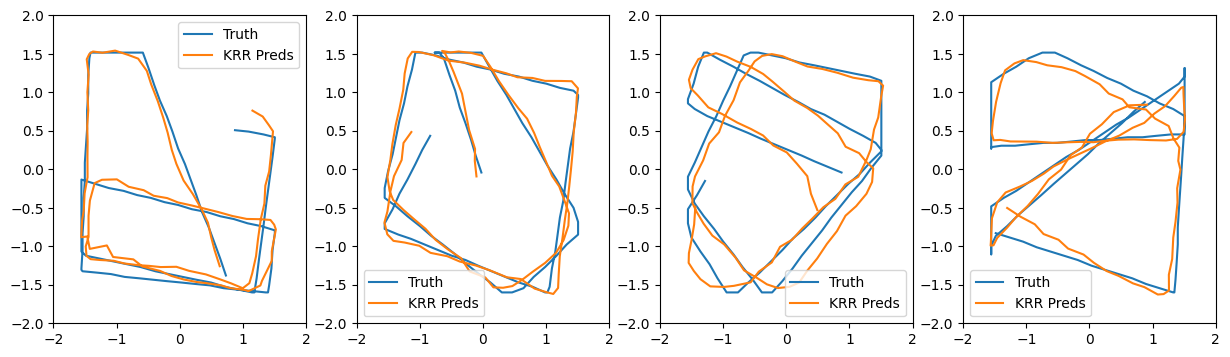

In [7]:
krr_preds = krr.predict(train_ts_means)
# val_krr_preds = krr.predict(val_X)

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
counter = 0
for i in range(4):
    ax[i].plot(train_Y[counter, :, 0], train_Y[counter, :, 1], label="Truth")
    ax[i].plot(krr_preds[counter, :, 0], krr_preds[counter, :, 1], label="KRR Preds")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
    ax[i].legend()
    counter += 1
plt.show()

In [32]:
# # load params
# filename = f"{PARAM_PREFIX}_params.pkl"
# with open(filename, 'rb') as f:
#     params = pickle.load(f)

# trainer.params = params

In [34]:
# apply = vmap(model.apply, (None, 0))
# train_ts_means = apply(trainer.params, train_X).smoothed_means
# val_ts_means = apply(trainer.params, val_X).smoothed_means

# # standardize the posterior means output
# train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)

In [35]:
# train_ts_means.shape, val_ts_means.shape

((200, 100, 32), (50, 100, 32))

In [36]:
# sigma_range = np.arange(0.01, 2, 0.1)
# lambda_range = np.arange(0.001, 0.2, 0.02)
# krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
# aux


itting KRR: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.84s/it]

{'sigma': Array(1.11, dtype=float32),
 'lambda': Array(0.061, dtype=float32),
 'r2': Array(0.9369173, dtype=float32)}